
원본 데이터 분포:
학습 데이터: 0.0    0.780822
1.0    0.219178
Name: proportion, dtype: float64
테스트 데이터: 1.0    0.5
0.0    0.5
Name: proportion, dtype: float64
원본 데이터 크기: 219
다수 클래스(0) 샘플 수: 171
타겟 소수 클래스(1) 샘플 수: 136
리샘플링 후 데이터 크기: 303
클래스 분포:
0.0    0.557756
1.0    0.442244
Name: proportion, dtype: float64

밸런싱 후 학습 데이터 분포:
0.0    0.557756
1.0    0.442244
Name: proportion, dtype: float64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 192ms/step - accuracy: 0.4116 - loss: 1.5388 - val_accuracy: 0.9836 - val_loss: 0.3427 - learning_rate: 0.0010
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.4919 - loss: 1.2504 - val_accuracy: 0.9836 - val_loss: 0.2205 - learning_rate: 0.0010
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.5025 - loss: 1.2025 - val_accuracy: 0.9836 - val_loss: 0.2434 - learning_rate: 0.0010
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5529 - loss: 1.2221 - val_accuracy: 0.9836 - val_loss: 0.2380 - learning_rate: 0.0010
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6024 - loss: 1.1240 - val_accuracy: 1.0000 - val_loss: 0.2173 - learning_rate: 0.0010
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6305 - loss: 1.0755 - val_accuracy: 1.0000 - val_loss: 0.1746 - learning_rate: 0.0010
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6759 - loss: 0.8987 - val_accuracy: 1.000

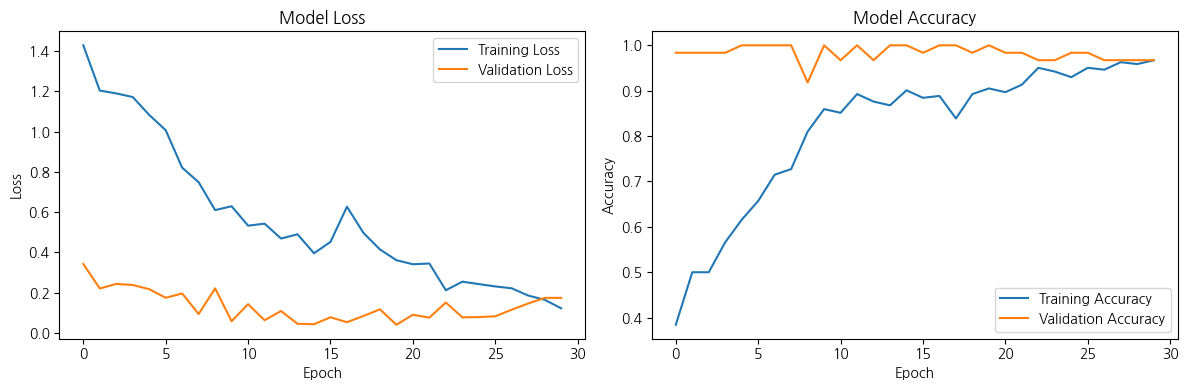

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step

=== 임계값 0.5 성능 ===
              precision    recall  f1-score   support

          하락       0.77      0.56      0.65        18
          상승       0.65      0.83      0.73        18

    accuracy                           0.69        36
   macro avg       0.71      0.69      0.69        36
weighted avg       0.71      0.69      0.69        36



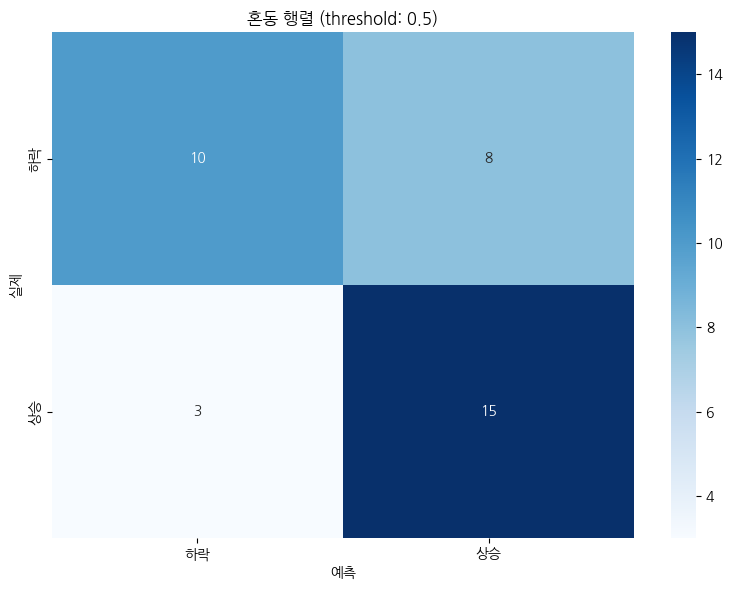


=== 임계값 0.4 성능 ===
              precision    recall  f1-score   support

          하락       0.77      0.56      0.65        18
          상승       0.65      0.83      0.73        18

    accuracy                           0.69        36
   macro avg       0.71      0.69      0.69        36
weighted avg       0.71      0.69      0.69        36



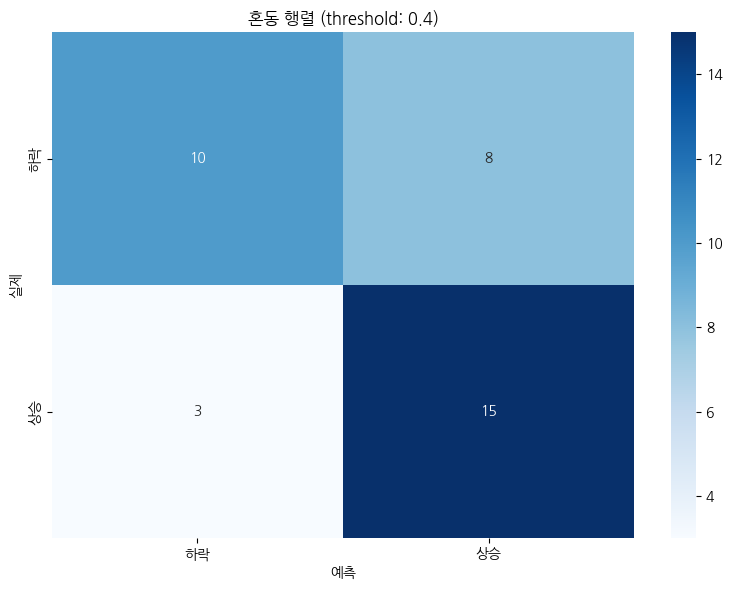


=== 임계값 0.3 성능 ===
              precision    recall  f1-score   support

          하락       0.77      0.56      0.65        18
          상승       0.65      0.83      0.73        18

    accuracy                           0.69        36
   macro avg       0.71      0.69      0.69        36
weighted avg       0.71      0.69      0.69        36



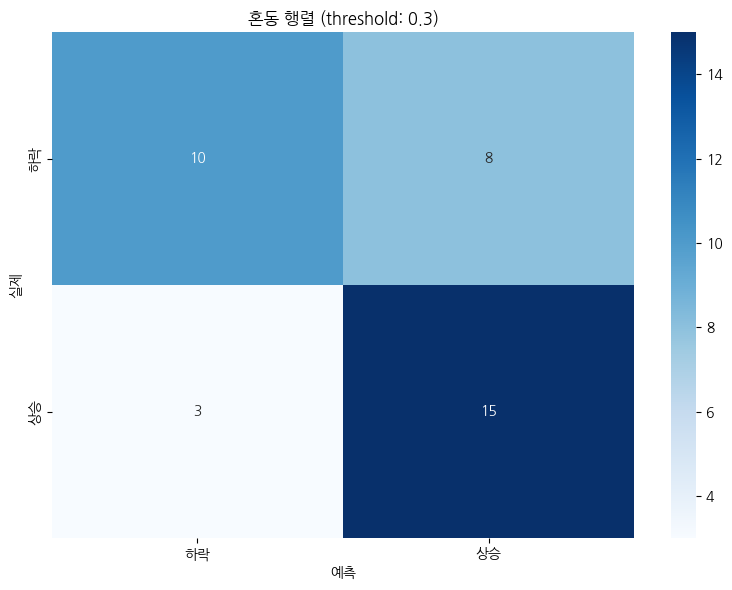


=== 임계값 0.2 성능 ===
              precision    recall  f1-score   support

          하락       0.77      0.56      0.65        18
          상승       0.65      0.83      0.73        18

    accuracy                           0.69        36
   macro avg       0.71      0.69      0.69        36
weighted avg       0.71      0.69      0.69        36



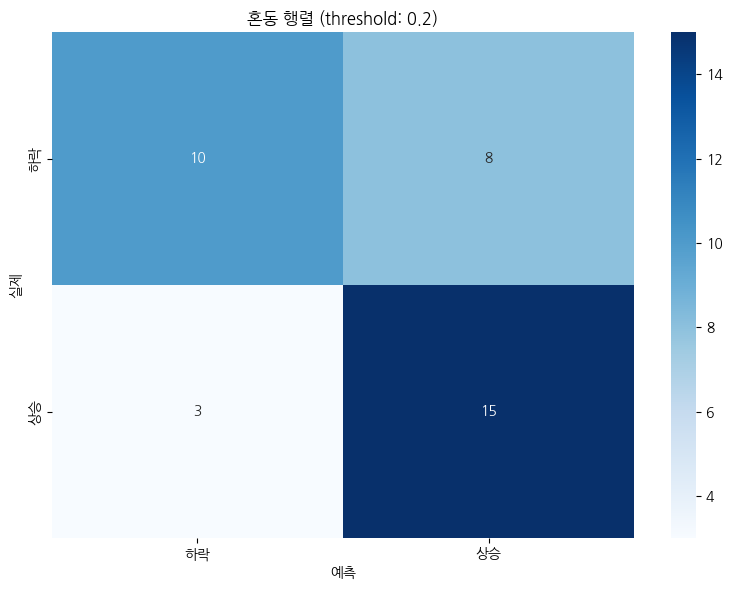

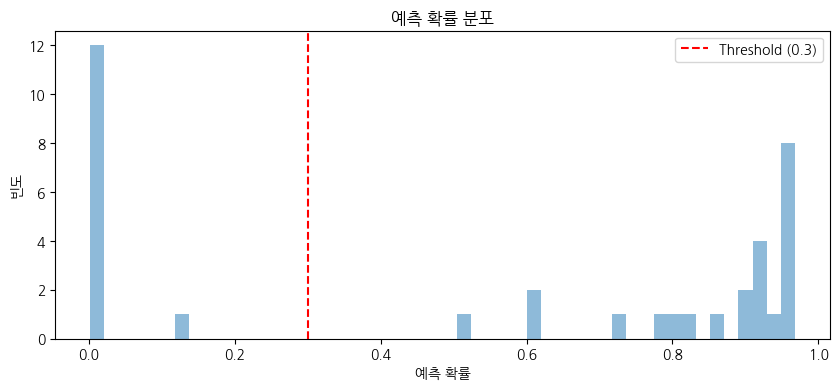

In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from imblearn.combine import SMOTETomek
import koreanize_matplotlib
import random

# 랜덤 시드 고정
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# 초기 설정
features = [
    '건설기성액_총액',
    '전산업생산지수_서비스업',
    '경기종합지수_후행종합지수',
    '경기종합지수_선행종합지수',
    '소매판매액지수',
    '비경제활동인구_60세이상',
    '소비자물가지수',
    '전산업생산지수_총계',
    '경기종합지수_동행종합지수',
    '전산업생산지수_광공업',
    '비경제활동인구_총계',
    '비경제활동인구_50-59세'
]

def prepare_data(data):
    # 기본 전처리
    df = data.set_index('지표').T

    # 숫자형으로 변환
    for col in df.columns:
        df[col] = pd.to_numeric(df[col].str.replace(',', ''), errors='coerce')

    # CD 금리 변화량 계산 및 방향성 레이블 생성
    df['CD_변화량'] = df['시장금리_CD'].diff()
    # 0.15는 꽤 괜찮긴한데...
    df['방향성'] = np.where(df['CD_변화량'] > 0.05, 1, 0)
    df['방향성'] = df['방향성'].fillna(0)

    # 변동성 특성 추가
    for col in features:
        df[f'{col}_변화율'] = df[col].pct_change(fill_method=None)
        df[f'{col}_이동평균'] = df[col].rolling(window=3, min_periods=1).mean()
        df[f'{col}_변동성'] = df[col].rolling(window=5, min_periods=1).std()
        df[f'{col}_모멘텀'] = df[col].pct_change(periods=3, fill_method=None)

    # NA 값 처리
    for col in df.columns:
        if '_변화율' in col or '_모멘텀' in col:
            df[col] = df[col].fillna(0)
        elif '_변동성' in col:
            df[col] = df[col].bfill()  # fillna(method='bfill') 대신 bfill() 사용

    df = df.dropna()
    return df

def create_sequences(data, feature_list, sequence_length=8):
    # 특성 컬럼 생성
    feature_columns = []
    for f in feature_list:
        feature_columns.extend([
            f, f'{f}_변화율', f'{f}_이동평균',
            f'{f}_변동성', f'{f}_모멘텀'
        ])

    # 데이터 분리
    X = data[feature_columns].values
    y = data['방향성'].values

    # 시퀀스 생성
    X_seq, y_seq = [], []
    for i in range(len(data) - sequence_length):
        X_seq.append(X[i:(i + sequence_length)])
        y_seq.append(y[i + sequence_length])

    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

def balance_data(X_train, y_train):
    # 3D → 2D 변환
    n_samples, timesteps, features = X_train.shape
    X_reshaped = X_train.reshape(n_samples, timesteps * features)

    # 현재 다수 클래스의 샘플 수 계산
    n_majority = sum(y_train == 0)

    # SMOTETomek 적용
    # 소수 클래스를 다수 클래스의 80% 수준으로 증가
    target_ratio = 0.8
    target_minority = int(n_majority * target_ratio)

    smt = SMOTETomek(
        sampling_strategy={1: target_minority},  # 소수 클래스(1)만 타겟 개수 지정
        random_state=42
    )

    print(f"원본 데이터 크기: {len(y_train)}")
    print(f"다수 클래스(0) 샘플 수: {n_majority}")
    print(f"타겟 소수 클래스(1) 샘플 수: {target_minority}")

    X_res, y_res = smt.fit_resample(X_reshaped, y_train)

    print(f"리샘플링 후 데이터 크기: {len(y_res)}")
    print("클래스 분포:")
    print(pd.Series(y_res).value_counts(normalize=True))

    # 2D → 3D 변환
    X_balanced = X_res.reshape(-1, timesteps, features)

    return X_balanced, y_res

def plot_confusion_matrix(y_true, y_pred, title, threshold):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['하락', '상승'], yticklabels=['하락', '상승'])
    plt.title(f'{title} (threshold: {threshold})')
    plt.ylabel('실제')
    plt.xlabel('예측')
    plt.tight_layout()
    plt.show()

def plot_prediction_distribution(y_pred_prob, threshold=0.3):
    plt.figure(figsize=(10, 4))
    plt.hist(y_pred_prob, bins=50, alpha=0.5)
    plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
    plt.title('예측 확률 분포')
    plt.xlabel('예측 확률')
    plt.ylabel('빈도')
    plt.legend()
    plt.show()

def evaluate_with_threshold(y_true, y_pred_prob, threshold, print_results=True):
    y_pred = (y_pred_prob > threshold).astype(int)
    if print_results:
        print(f"\n=== 임계값 {threshold} 성능 ===")
        print(classification_report(y_true, y_pred,
                                target_names=['하락', '상승'],
                                zero_division=0))
    return y_pred

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    # 1. 데이터 로드 및 전처리
    data = pd.read_csv('features.csv')
    df = prepare_data(data)

    # 2. 특성 스케일링
    scaler = StandardScaler()

    # 스케일링할 특성 선택
    feature_columns = []
    for f in features:
        feature_columns.extend([
            f, f'{f}_변화율', f'{f}_이동평균',
            f'{f}_변동성', f'{f}_모멘텀'
        ])

    # 특성만 스케일링
    df[feature_columns] = scaler.fit_transform(df[feature_columns])

    # 3. 시퀀스 데이터 생성
    sequence_length = 6
    X, y = create_sequences(df, features, sequence_length)

    # 4. 데이터 분할
    test_size = 36
    train_size = len(X) - test_size

    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    print("\n원본 데이터 분포:")
    print("학습 데이터:", pd.Series(y_train).value_counts(normalize=True))
    print("테스트 데이터:", pd.Series(y_test).value_counts(normalize=True))

    # 5. 데이터 밸런싱
    X_train_balanced, y_train_balanced = balance_data(X_train, y_train)

    print("\n밸런싱 후 학습 데이터 분포:")
    print(pd.Series(y_train_balanced).value_counts(normalize=True))

    # 6. 모델 정의
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True),
                     input_shape=(sequence_length, X_train.shape[2])),
        Dropout(0.4),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.4),
        Bidirectional(LSTM(32)),
        Dropout(0.4),
        Dense(32, activation='relu'),
        Dropout(0.4),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    # 7. 컴파일 설정
    class_weight = {0: 1.0, 1: 5.0}  # 상승 클래스에 5배 가중치

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # 8. 콜백 정의
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=0.0001,
            verbose=1
        )
    ]

    # 9. 모델 학습
    history = model.fit(
        X_train_balanced, y_train_balanced,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=callbacks,
        class_weight=class_weight,
        verbose=1
    )

    # 10. 학습 과정 시각화
    plot_training_history(history)

    # 11. 예측 및 평가
    y_pred_prob = model.predict(X_test)

    # 다양한 임계값으로 성능 평가
    thresholds = [0.5, 0.4, 0.3, 0.2]
    for threshold in thresholds:
        y_pred = evaluate_with_threshold(y_test, y_pred_prob, threshold)
        plot_confusion_matrix(y_test, y_pred, '혼동 행렬', threshold)

    # 예측 확률 분포 시각화
    plot_prediction_distribution(y_pred_prob)

if __name__ == "__main__":
    main()

In [2]:
!pip install koreanize-matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 45.8 MB/s eta 0:00:00
